In [95]:
from icecube import icetray, dataio, dataclasses, simclasses, MuonGun

import numpy as np
import matplotlib as mpl
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt

%matplotlib inline

In [100]:
plt.rcParams.update({'font.size': 20})
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

mpl.rcParams['hist.bins'] = 100
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['patch.linewidth'] = 2.5
mpl.rcParams['grid.alpha'] = 0.2

# selection by Truth properties

__reading from file__
-------------------------------

here I'm readig from 1 file; 
you can add file loop later.

here we are saving 3 __true__ parameters:

1. total energy loss by muon (during it's simulated path)
2. muon path length
3. muon initial energy (at the beginnig of simulated path)

In [111]:
en_ini = []; en_loss = []; dist = []
zen = []

with dataio.I3File('MCdata/83.i3.bz2') as f:
    for fr in f:
        if not 'TruthEnergy' in fr.keys(): continue
        en_loss.append(fr['TruthEnergy'].value)    # total energy loss by muon
        dist.append(fr['TruthMuon'].length)        # muon path length
        en_ini.append(fr['TruthMuon'].energy/icetray.I3Units.GeV)      # muon initial energy
        zen.append(fr['TruthMuon'].dir.zenith/icetray.I3Units.deg)

In [112]:
en_ini = np.array(en_ini); en_loss = np.array(en_loss); dist = np.array(dist)
zen = np.array(zen)

In [98]:
# average(!) energy loss per distance
dEdx = en_loss/dist

__muon initial energy distribution__
----------------------------------------------------

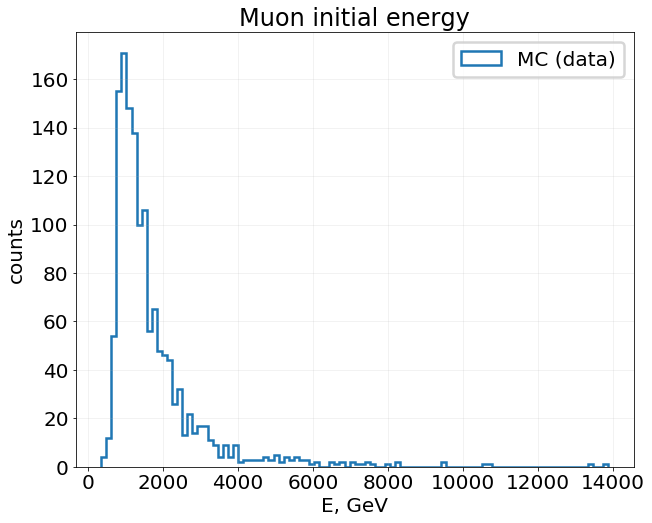

In [103]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon initial energy')
ax.set_ylabel('counts')
ax.set_xlabel(r'E, GeV')

plt.hist(en_ini, histtype='step', label = 'MC (data)')

ax.grid()
plt.legend()
plt.show()

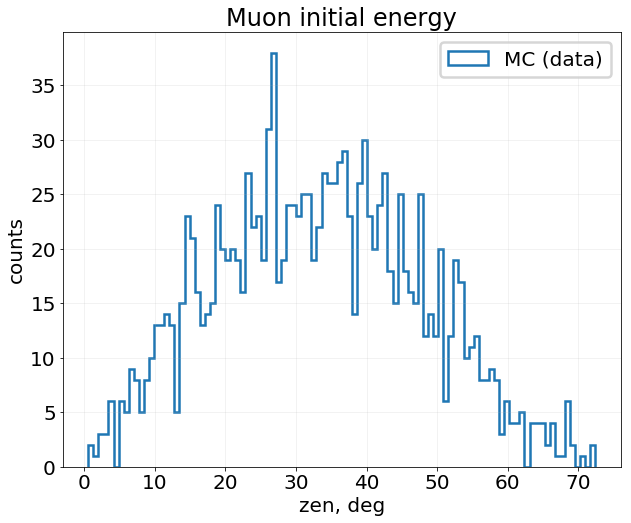

In [114]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon initial energy')
ax.set_ylabel('counts')
ax.set_xlabel(r'zen, deg')

plt.hist(zen, histtype='step', label = 'MC (data)')

ax.grid()
plt.legend()
plt.show()

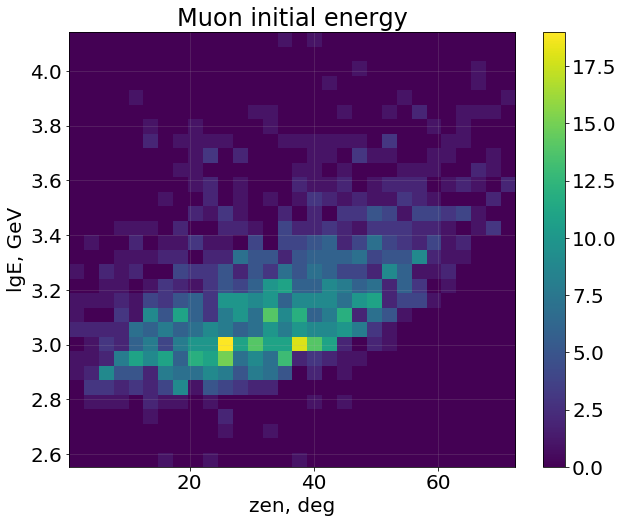

In [122]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon initial energy')
ax.set_ylabel('lgE, GeV')
ax.set_xlabel(r'zen, deg')

h = plt.hist2d(zen, np.log10(en_ini), 30,
               norm=Normalize())

ax.grid()
plt.colorbar(h[3])
plt.show()

In [105]:
bins = 10.**(np.linspace(np.log10(min(en_ini)), np.log10(max(en_ini)), 100))

/home/maria/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


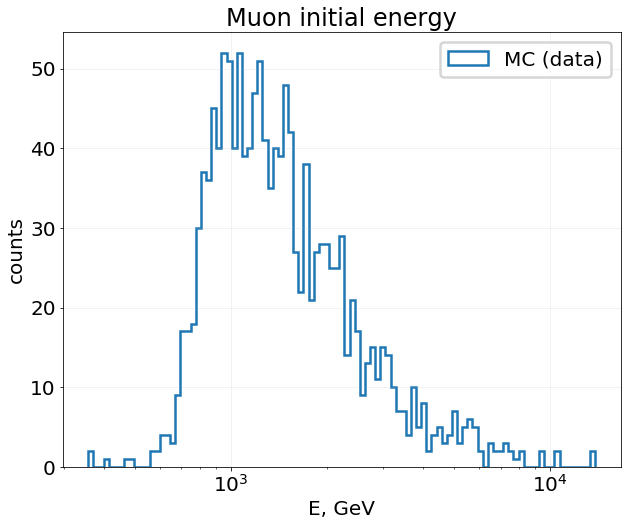

In [107]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon initial energy')
ax.set_ylabel('counts')
ax.set_xlabel(r'E, GeV')
ax.set_xscale('log')

plt.hist(en_ini, bins, histtype='step', label = 'MC (data)')

ax.grid()
plt.legend()
plt.show()

- why do we see difference from distr for atm muons in pdg?
- is it because low energy muons are much harder to detect/recnstruct??

__first look at energy loss distribution__ 
---------------------------------------------------------

two questions here:
- what do we expect to see?
- does our dictribution look as expected?

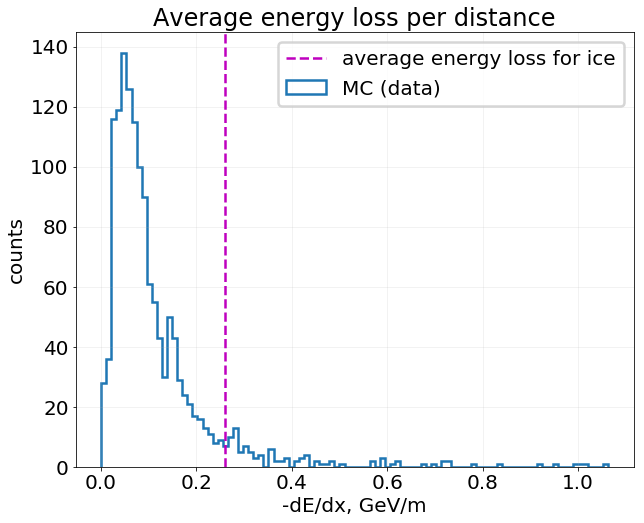

In [50]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Average energy loss per distance')
ax.set_ylabel('counts')
ax.set_xlabel(r'-dE/dx, GeV/m')

plt.hist(dEdx, histtype='step', label = 'MC (data)')

plt.axvline(0.259, c='m', linestyle='--', label='average energy loss for ice')

ax.grid()
plt.legend()
plt.show()

In [32]:
from scipy.optimize import curve_fit
import pylandau

In [33]:
hcounts, hbinedges = np.histogram(dEdx, 100)
hbinccenters = hbinedges[:-1] + 0.5*(hbinedges[1] - hbinedges[0])

In [34]:
nn = 32 # here I have too few entries in the tail which mess up the fit; solution -> cut them by hand
mpv, eta, sigma, A = 4.5, 1.8, 1., 140. # initial point - sel by hand

coeff, pcov = curve_fit(pylandau.langau, 
                        hbinccenters[:nn]*100., hcounts[:nn], # have to scale x - eta < 1 is not supported
                        sigma=np.sqrt(hcounts[:nn]),
                        absolute_sigma=True,
                        p0=(mpv, eta, sigma, A),
                        bounds=([1., 1., 0.001, 100.], [40., 10., 5., 200.]))

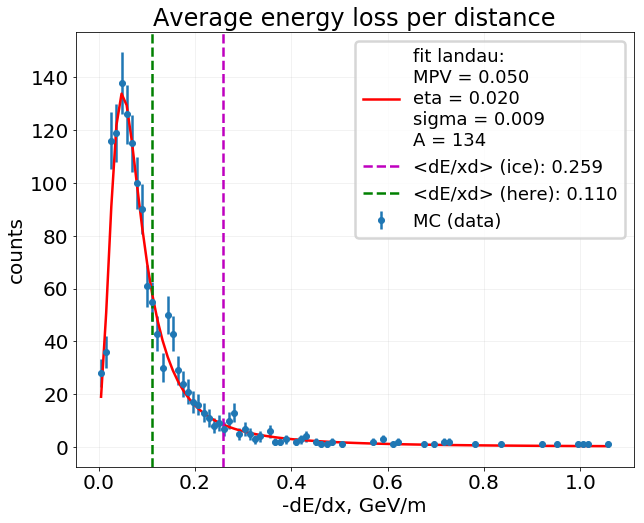

In [102]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Average energy loss per distance')
ax.set_ylabel('counts')
ax.set_xlabel(r'-dE/dx, GeV/m')

pl = (hcounts > 0)

plt.errorbar(hbinccenters[pl], hcounts[pl], yerr=np.sqrt(hcounts[pl]), fmt='o',
            label = 'MC (data)')
plt.plot(hbinccenters, pylandau.langau(hbinccenters*100., *coeff), 'r-',
        label='fit landau:\nMPV = {:.3f}\neta = {:.3f}\nsigma = {:.3f}\nA = {:.0f}'.format(
            coeff[0]/100., coeff[1]/100., coeff[2]/100., coeff[3]))

plt.axvline(0.259, c='m', linestyle='--', label='<dE/xd> (ice): {}'.format(0.259))
plt.axvline(np.mean(dEdx), c='g', linestyle='--', label='<dE/xd> (here): {:.3f}'.format(np.mean(dEdx)))


# t = np.linspace(0., max(hbinccenters)*100., 1000)
# mt = np.mean( pylandau.langau(t, *coeff))/100.
# plt.axvline(mt, 
#             c='k', linestyle='--', 
#             label='<dE/xd> (fit): {:.3f}'.format(mt))

ax.grid()
plt.legend(fontsize=18)
plt.show()

# muon selection 
__(just one way of doing it, there are more)__

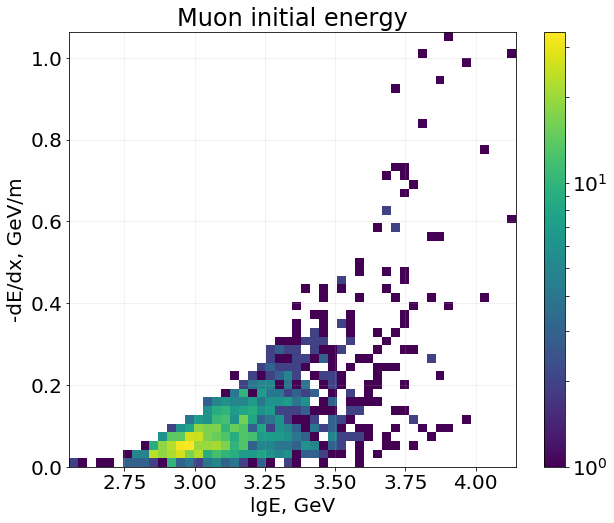

In [125]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon initial energy')
ax.set_xlabel('lgE, GeV')
ax.set_ylabel('-dE/dx, GeV/m')

h = plt.hist2d(np.log10(en_ini), dEdx, 50,
               norm=LogNorm())

ax.grid()
plt.colorbar(h[3])
plt.show()

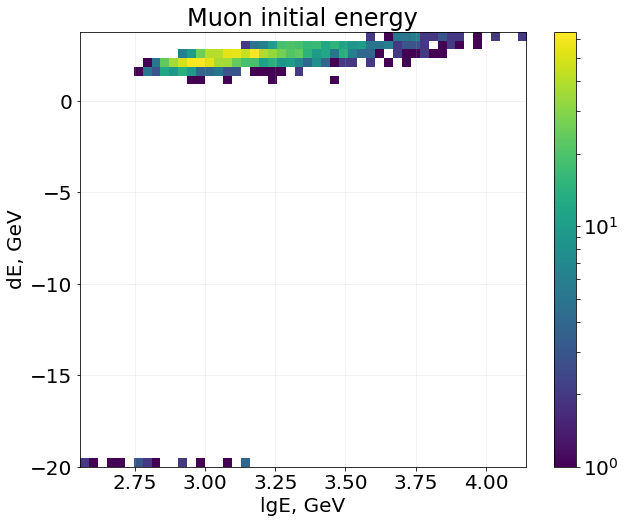

In [129]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon initial energy')
ax.set_xlabel('lgE, GeV')
ax.set_ylabel('dE, GeV')

h = plt.hist2d(np.log10(en_ini), np.log10(en_loss), 50,
               norm=LogNorm())

ax.grid()
plt.colorbar(h[3])
plt.show()

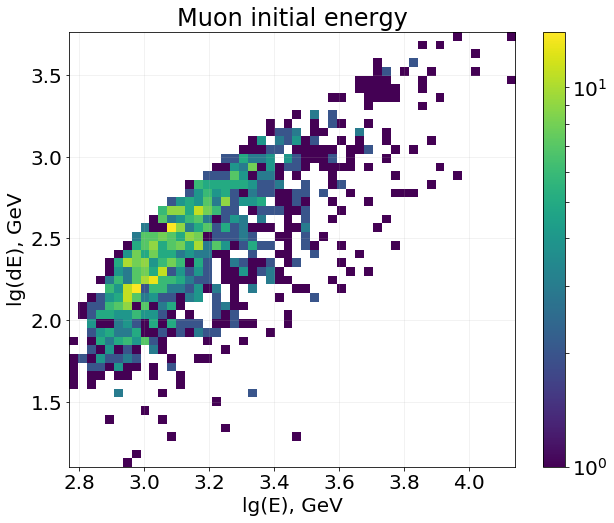

In [131]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon initial energy')
ax.set_xlabel('lg(E), GeV')
ax.set_ylabel('lg(dE), GeV')

ind = (np.log10(en_loss)>0.)

h = plt.hist2d(np.log10(en_ini[ind]), np.log10(en_loss[ind]), 50,
               norm=LogNorm())

ax.grid()
plt.colorbar(h[3])
plt.show()

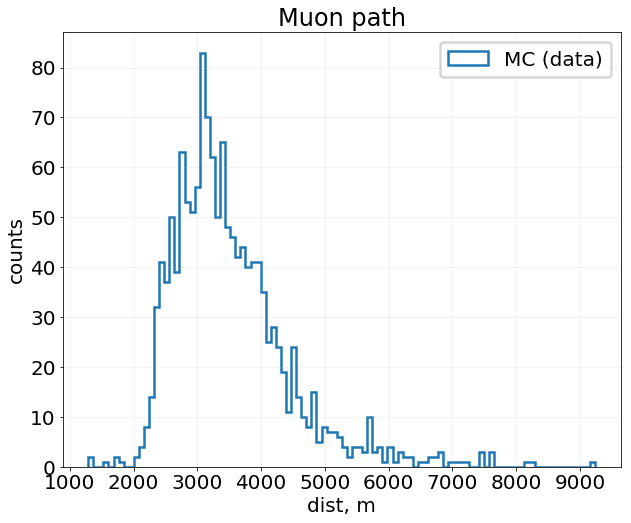

In [132]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon path')
ax.set_ylabel('counts')
ax.set_xlabel('dist, m')

plt.hist(dist, histtype='step', label = 'MC (data)')

ax.grid()
plt.legend()
plt.show()

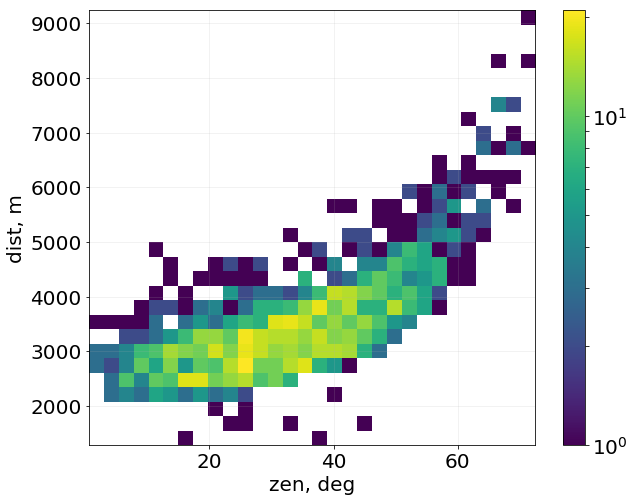

In [134]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
# ax.set_title('Muon initial energy')
ax.set_ylabel('dist, m')
ax.set_xlabel('zen, deg')

h = plt.hist2d(zen, dist, 30,
               norm=LogNorm())

ax.grid()
plt.colorbar(h[3])
plt.show()

true_muon.length != path for true_en_loss??

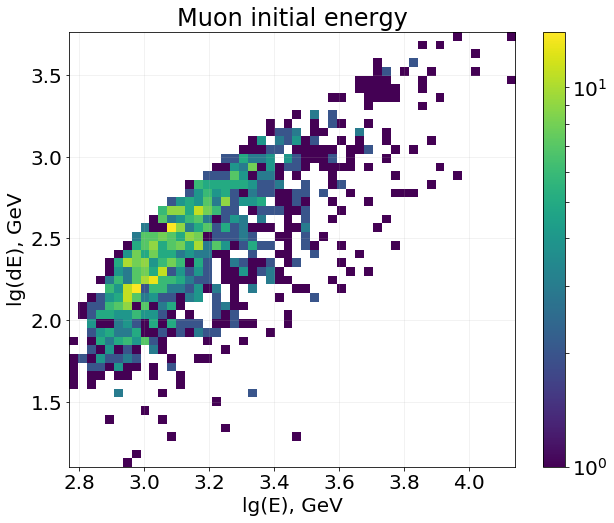

In [131]:
fig = plt.figure(1, figsize=(10, 8))
ax = plt.gca()
ax.set_title('Muon initial energy')
ax.set_xlabel('lg(E), GeV')
ax.set_ylabel('lg(dE), GeV')

ind = (np.log10(en_loss)>0.)
ind_dist = (dist >)

h = plt.hist2d(np.log10(en_ini[ind]), np.log10(en_loss[ind]), 50,
               norm=LogNorm())

ax.grid()
plt.colorbar(h[3])
plt.show()